In [1]:
import sys
import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')
from skimage.morphology import square,dilation
sys.path.append(r'/home/localuser/Datacube/data_cube_notebooks/cloudless')
from datetime import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scripts.data import *
from scripts.combiner import *
from scripts.view import *
import time
import cv2
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor #Multilayer perceptron 
from sklearn import linear_model,metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error,mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_squared_log_error, median_absolute_error, r2_score
from sklearn.svm import LinearSVR

In [2]:
def NDVI(composite):
    return (composite[3,:,:] - composite[0,:,:])/(composite[3,:,:] + composite[0,:,:])[np.newaxis,:,:]
def intensity(composite):
    return ((0.42*composite[2,:,:]+0.98*composite[1,:,:]+0.6*composite[0,:,:]+composite[3,:,:])/3)[np.newaxis,:,:]

In [3]:
clear_comp = np.load('test.npy')
Y_TRUE =  np.load('Y_true.npy')

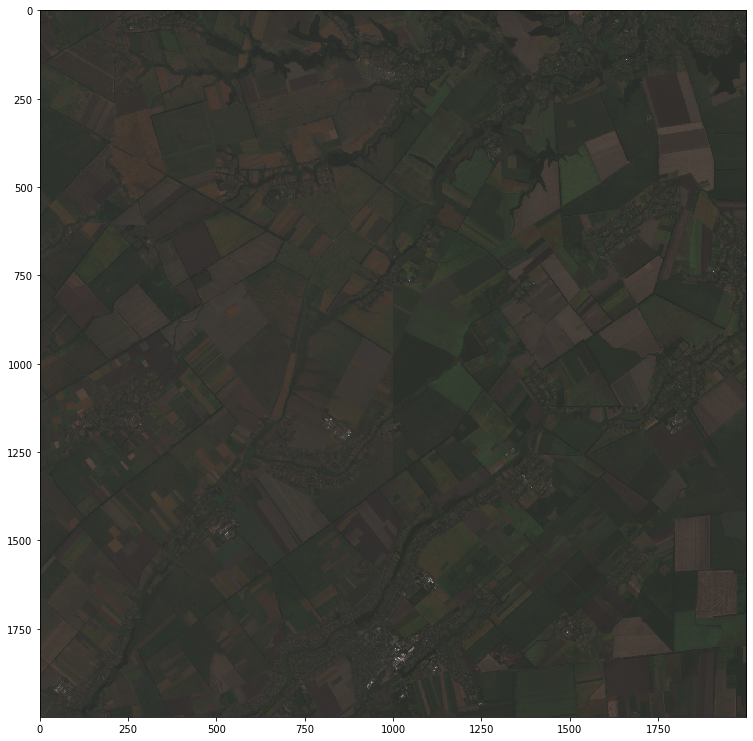

In [6]:
plot_composite(clear_comp)

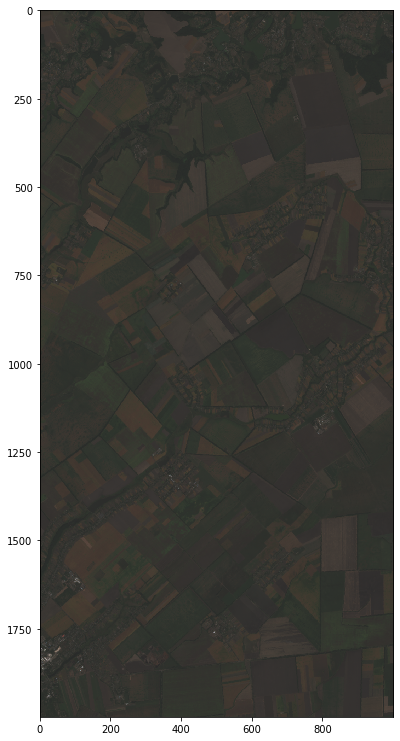

In [100]:
plot_composite(Y_TRUE)

# Вибираємо зону стику, де пертинаються навчальні дані.

In [4]:
region_op = clear_comp[:,:,800:1100] # опорний
region_neop = clear_comp[:,:,900:1200] #неопорний

In [8]:
region_neop.shape, region_op.shape

((4, 2000, 300), (4, 2000, 300))

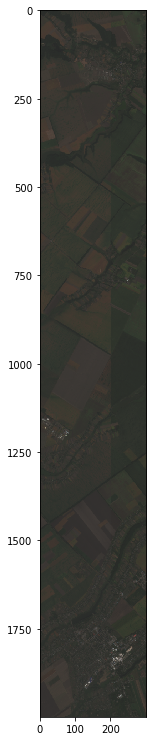

In [9]:
plot_composite(region_op)

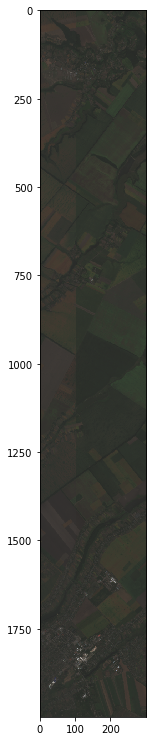

In [10]:
plot_composite(region_neop)

In [5]:
from sklearn.model_selection import train_test_split
def preparing_data(region_op, region_neop):
    #creating data
    X  = np.copy(region_neop)
    Y = np.copy(region_op)
    X_test = clear_comp[:,:,1000:]
    y_test = clear_comp[:,:,:1000]
    
    #adding two bands
    X = np.vstack([X,NDVI(X),intensity(X)])
    Y = np.vstack([Y,NDVI(Y),intensity(Y)])
    X_test = np.vstack([X_test,intensity(X_test), NDVI(X_test)])
    y_test = np.vstack([y_test,intensity(y_test), NDVI(y_test)])
    
    #reshaping
    X = np.moveaxis(X,0,-1)
    Y = np.moveaxis(Y,0,-1)
    X_test = np.moveaxis(X_test,0,-1).reshape(-1,6)
    y_test = np.moveaxis(y_test,0,-1).reshape(-1,6)
    
    #spliting
    X_train, x_None, y_train, y_None = train_test_split(X ,Y, test_size=1, random_state=42)
    X_train = X_train.reshape(-1,6)
    y_train = y_train.reshape(-1,6)
    x_None = None
    y_None = None
    
    #scaling
    for i in range(6):
        X_train[:,i] = StandardScaler().fit_transform(X_train[:,i].reshape(-1,1)).ravel()
        X_test[:,i] = StandardScaler().fit_transform(X_test[:,i].reshape(-1,1)).ravel()
        
    # X_train now is scaled
    # X_test now is scaled
    return (X_train, X_test, y_train, y_test)

In [7]:
import time
from sklearn.preprocessing import PolynomialFeatures
def try_polreg(prepeared_data):
    X_train_scaled = prepeared_data[0]
    X_test_scaled = prepeared_data[1]
    y_train = prepeared_data[2]
    y_test = prepeared_data[3]
    
    result = np.empty_like(X_test_scaled)
    print(X_train_scaled.shape)
    bands = X_train_scaled.shape[1]
    
    poly_features = PolynomialFeatures(degree=6)
    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train_scaled)
    
    for i in range(3):
        print('band',i)
        a = time.time()
        
        scaler_y =  StandardScaler().fit(y_train[:,i].reshape(-1,1))
        scaler_y_test = StandardScaler().fit(y_test[:,i].reshape(-1,1))
    
        Y_train_scaled = scaler_y.transform(y_train[:,i].reshape(-1,1))
        Y_test_scaled= scaler_y_test.transform(y_test[:,i].reshape(-1,1))
        
        
        
        polreg = linear_model.LinearRegression(n_jobs=-1)
        #print('Train the model using the training sets')
        
        polreg.fit(X_train_poly, Y_train_scaled.ravel())
        print("Time trainning:",(time.time()-a)/60,'min')
        train_time = time.time()
        
        #print('Make predictions using the testing set')
        Y_pred_scaled = polreg.predict(poly_features.fit_transform(X_test_scaled))              
        print("Time predicting:",(time.time()-train_time)/60,'min')
    
        #print('svr score: %.4f' % svr.score(X_test, Y_test))
        
        
        #X_test = scaler_x_test.inverse_transform(X_test_scaled)
        Y_pred = scaler_y_test.inverse_transform(Y_pred_scaled)
        Y_test = scaler_y_test.inverse_transform(Y_test_scaled)
        
                
        result[:,i] = Y_pred.ravel()
    
    result= result.reshape((2000,1000,bands))
    return result

In [8]:
prepeared_data = preparing_data(region_op, region_neop)
res = try_polreg(prepeared_data)
res = np.moveaxis(res, 2,0)

(599700, 6)
band 0
Time trainning: 0.7737846573193868 min
Time predicting: 1.2623769760131835 min
band 1
Time trainning: 0.7767874995867411 min
Time predicting: 1.2311517635981242 min
band 2
Time trainning: 0.7700292865435282 min
Time predicting: 1.2371391216913858 min


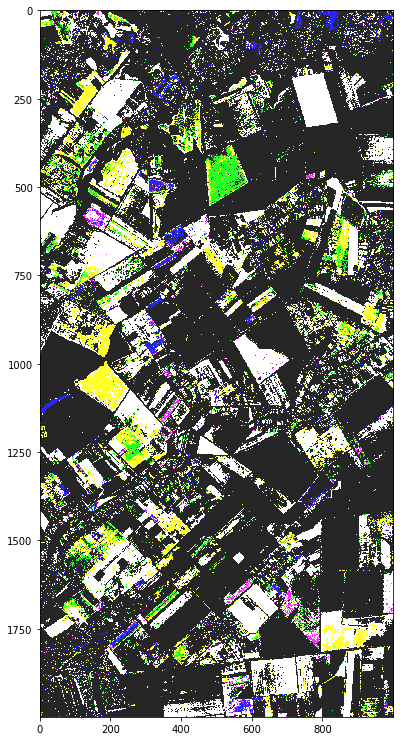

In [9]:
plot_composite(5*res.astype('float'))

## Results with mean

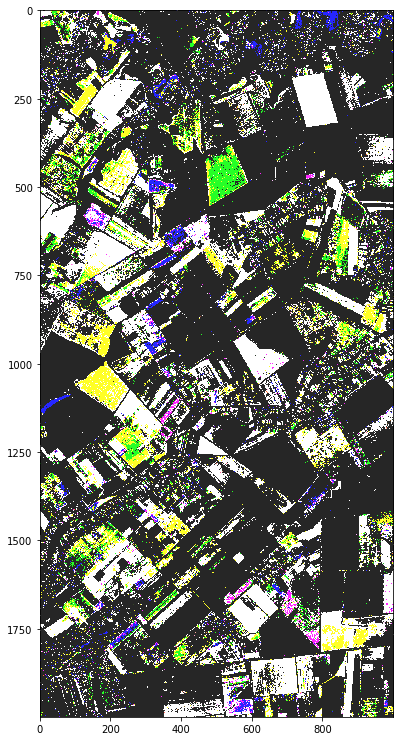

In [10]:
men = np.mean([clear_comp[:,:,1000:],res[:4,:,:]], axis=0)
plot_composite(men)

In [11]:
f = np.copy(clear_comp)
f[:,:,1000:] = men#res[:4,:,:]# men !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [12]:
res.shape

(6, 2000, 1000)

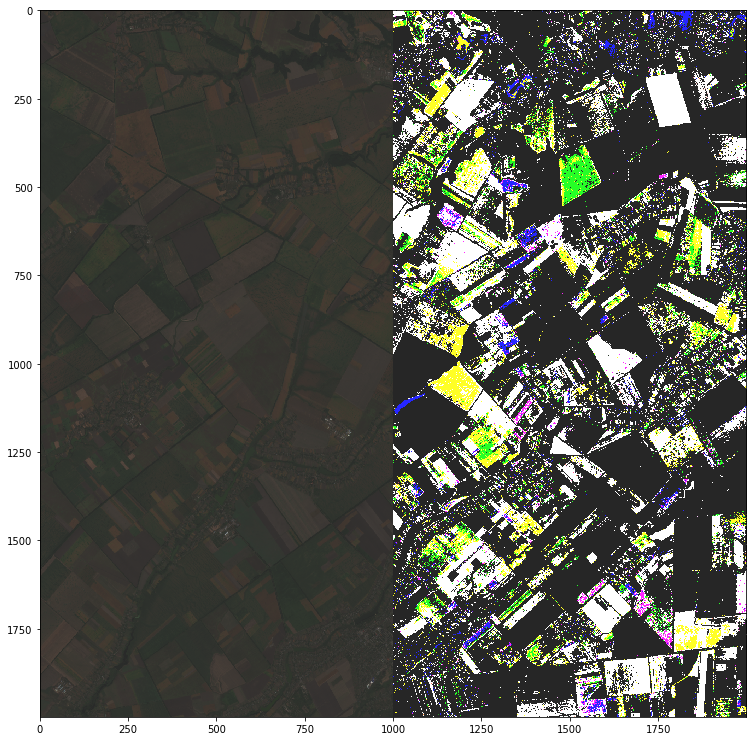

In [13]:
plot_composite(f)

# Stats

In [21]:
#LinearRegression()
stats(Y_TRUE.reshape(-1,1), men.reshape(-1,1))

explained_variance_score:  -2.255220770183811e+23
max_error:  1.6205276819322052e+16
mean_absolute_error:  252217931324033.9
mean_squared_error:  2.0243637557489146e+29
median_absolute_error:  122337750727503.53
r2_score:  -2.255220770183816e+23


In [16]:
stats(Y_TRUE.reshape(-1,1),res[:4,:,:].reshape(-1,1))

explained_variance_score:  -1.6867948910293948e+22
max_error:  1.0291352457319446e+17
mean_absolute_error:  535810039811.5182
mean_squared_error:  1.5141538330036827e+28
median_absolute_error:  2345007.0821378697
r2_score:  -1.6868268678225039e+22


In [ ]:
save_narray_no_xarray(f,'mlp.tiff')

In [26]:
def plot_band(composite,ind_band ,min_possible=0, max_possible=10000,min_inten=0.15, max_inten=1.0):
    """
    composite: - composite with bands RGBN, shape(4,x,y)

    """
    composite = composite[ind_band,:,:]
    min_rgb = min_possible
    max_rgb = max_possible
    composite = np.interp(composite, (min_rgb, max_rgb), [min_inten,max_inten])
    composite = composite.astype(float)
    figure(figsize=(13,13))
    return plt.imshow(composite)

In [32]:
def save_narray_no_xarray(array, path, pixel_size = 10):
    x_pixels = array.shape[2]  # number of pixels in x
    y_pixels = array.shape[1]  # number of pixels in y
    bands = array.shape[0]     # number of bands
        
    new_dataset = rasterio.open(path, 'w',
                                driver ='GTiff',
                                height = y_pixels,
                                width  = x_pixels,
                                count  = bands,
                                dtype  = array.dtype)
    for i in range(bands):
        new_dataset.write(array[i,:,:], i+1)
    new_dataset.close()

In [70]:
stats(Y_TRUE.reshape(-1,1), men.reshape(-1,1))#Y_TRUE.reshape(-1,1), men.reshape(-1,1))

explained_variance_score:  0.7032126643425032
max_error:  4750.308182918077
mean_absolute_error:  345.1733018229928
mean_squared_error:  348529.90912492503
median_absolute_error:  106.16204611621339
r2_score:  0.6117239859404502


In [39]:
res[:4,:,:].reshape(-1,1)

array([[798.32039608],
       [799.34356015],
       [791.27133343],
       ...,
       [  0.        ],
       [  0.        ],
       [  0.        ]])

In [37]:
Y_TRUE.shape

(4, 2000, 1000)

In [15]:
def stats(y_true,y_pred):
    print("explained_variance_score: ",explained_variance_score(y_true,y_pred))
    print("max_error: ",max_error(y_true, y_pred))
    print("mean_absolute_error: ",mean_absolute_error(y_true, y_pred))
    print("mean_squared_error: ",mean_squared_error(y_true, y_pred))
    print("median_absolute_error: ",median_absolute_error(y_true, y_pred))
    print("r2_score: ",r2_score(y_true, y_pred))